# Computer Vision & Deep Learning - Generative AI & Visual Synthesis

# Exercise 4: Convolutional Neural Networks

**Due on 24.05.2024., 10:00**

## Important notes

- Email: Frequently check your email address registered for Moodle. All notifications regarding the course will be sent via Moodle.
- Moodle: Please use the Moodle platform and post your questions to the forum. They will be answered by us or your fellow students.
-  Submission: Put your code and potentially other materials inside a single ZIP file. If you use jupyter notebooks, please always create a PDF file and include it in your ZIP file. The final submission should therefore be a **single zip** file with a **PDF of your code** and the **original code** inside. The ZIP file should contain your surname and your matriculation number (Surname-MatriculationNumber.zip). Submissions that fail to follow the naming convention will not be graded!

In [3]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T,datasets

---
## Task 3: Convolutional Neural Networks

In the previous exercise, we already used the PyTorch framework to train a neural network classifier. Now, we want to move on to a more complex dataset than MNIST and use a Convolutional Neural Network for classification.

### Task 3.1: Dataset

In [4]:
dataset = datasets.CIFAR10('./data',
                           train=True,
                           download=True, transform=T.Compose([
                           T.ToTensor()
                       ]))


Files already downloaded and verified


(50000, 32, 32, 3)
50000


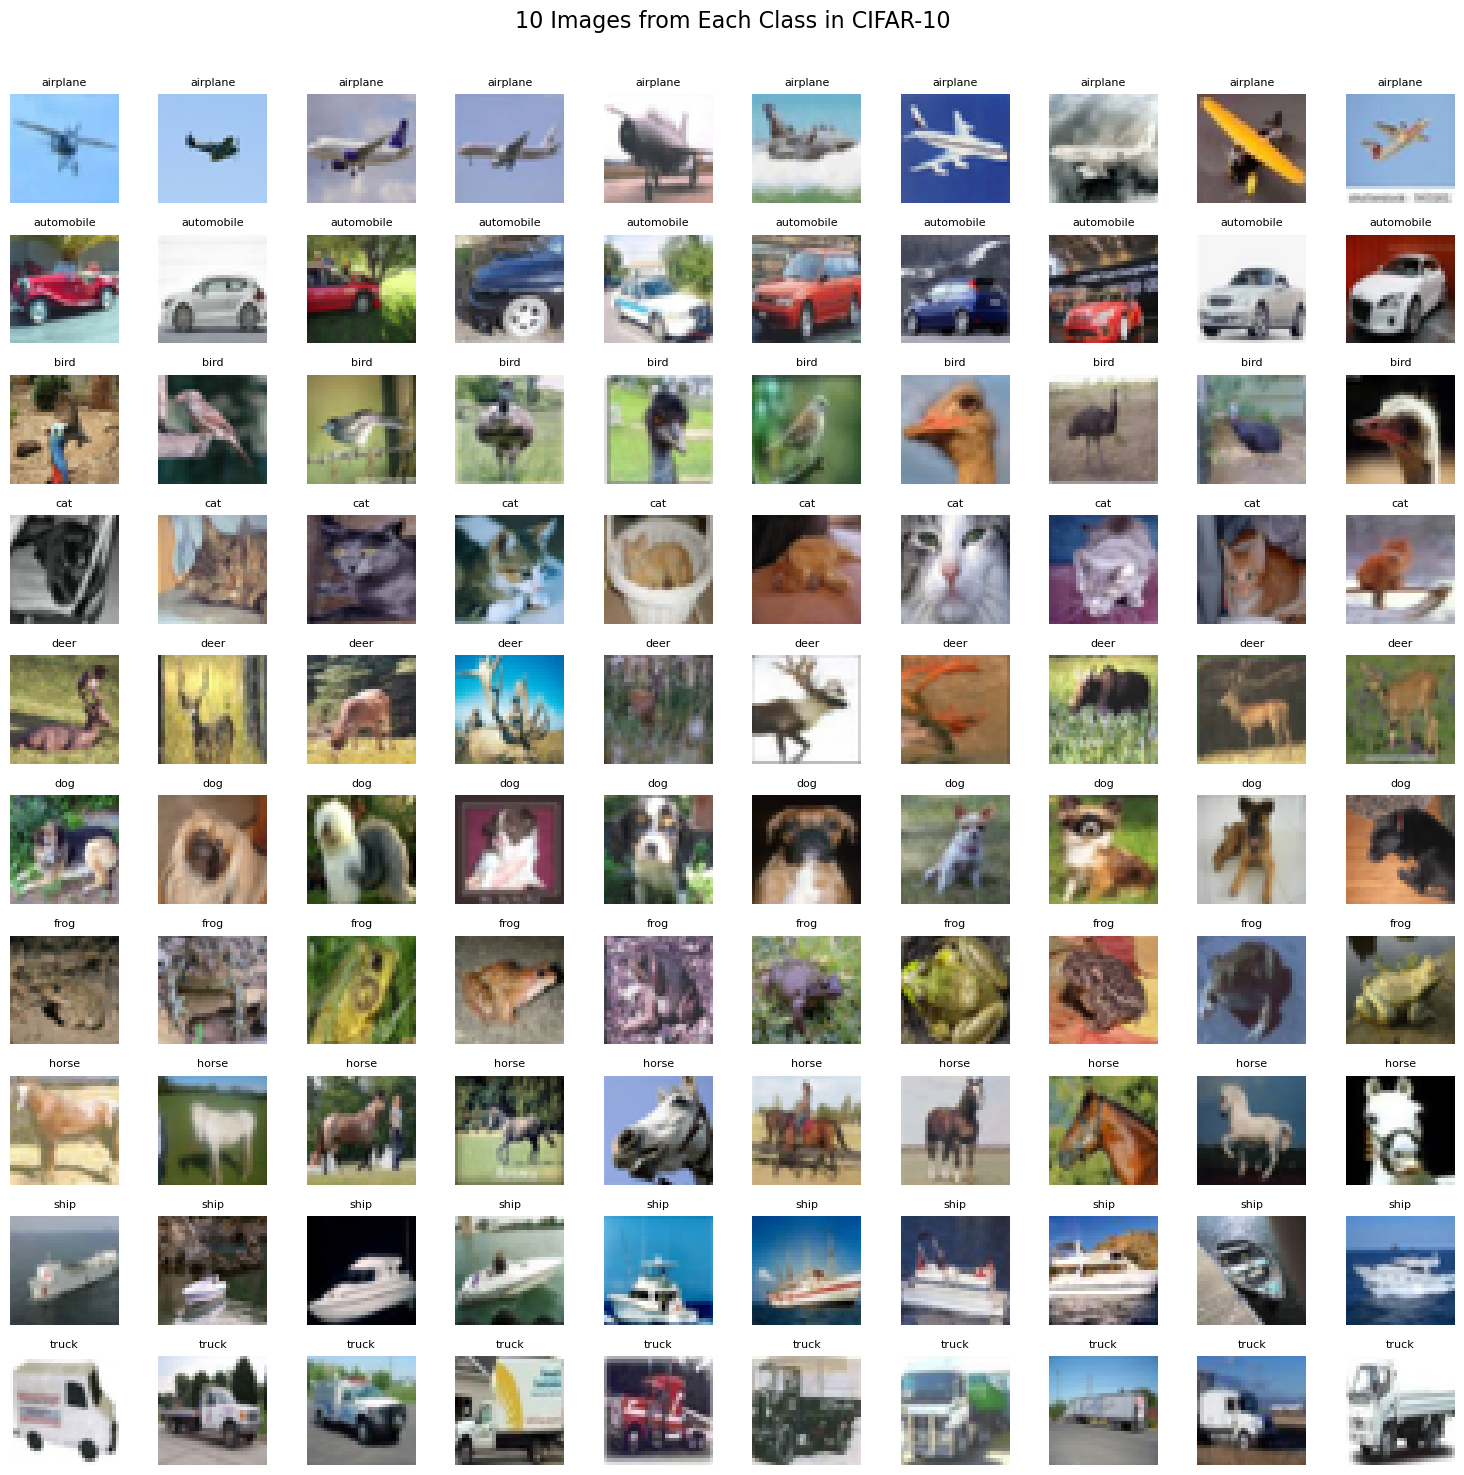

In [5]:
# TODO: Plot 10 images from each class

images = dataset.data # dimensions are 50000 samples/images with 32x32 pixels and 3 channels for colours (RGB)
labels = dataset.targets # list of 50000 entries for the labels of each image [0 to 9 so 10 classes]
print(images.shape)
print(len(labels))
#dictionary to save in form label:list_of_images
images_per_class = {i: [] for i in range(10)}

trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
class_names = dataset.classes

for images, labels in trainloader:
    label = labels.item()
    if len(images_per_class[label]) < 10:
        images_per_class[label].append(images)
    # Stop if we have 10 images for each class
    if all(len(images) >= 10 for images in images_per_class.values()):
        break

# Plot 10 images for each class
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle('10 Images from Each Class in CIFAR-10', fontsize=16)

for class_index, class_images in images_per_class.items():
    for img_index, img in enumerate(class_images):
        ax = axes[class_index, img_index]
        img = img.squeeze().permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        ax.imshow(img)
        ax.axis('off')
        if img_index == 0:
            ax.set_ylabel(class_names[class_index], rotation=90, size='large')
        ax.set_title(class_names[class_index], fontsize=8)  # Add class label as title

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### 3.2 Network

In [6]:
class Net(nn.Module):
    def __init__(self):
        ############ your code here ############
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0, stride=1) # 32x32 to 28x28x6
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2) # 28x28x6  to 14x14x6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1) # 14x14x6 to 10x10x16
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2) #10x10x16 to 5x5x16

        # fully connected layers
        # neurons means out_features
        self.fc1 = nn.Linear(in_features=400, out_features=120) # flatten output of self.max2 and those are input features for linear layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
        self.relu = nn.ReLU()
        
        ############ end of your code############
    
    def forward(self, x):
        ############ your code here ############
        out = self.conv1(x)
        out = self.relu(out)
        out = self.max1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.max2(out)
        out = out.view(-1,5*5*16)
        #fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        ############ end of your code############
        return out

### 3.3 Training

In [12]:
# TODO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=T.Compose([
                           T.ToTensor()
                       ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=T.Compose([
                           T.ToTensor()
                       ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=0)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total Trainable Parameters:", total_params)

train_accuracy_normal_list = []
test_accuracy_normal_list = []

for epoch in range(10):  # 10 epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Evaluate on training set
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
    train_accuracy = 100 * correct_train / total_train
    train_accuracy_normal_list.append(train_accuracy)

    # Evaluate on test set
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    test_accuracy_normal_list.append(test_accuracy)


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Total Trainable Parameters: 62006
[1,  2000] loss: 1.764
[2,  2000] loss: 1.401
[3,  2000] loss: 1.286
[4,  2000] loss: 1.193
[5,  2000] loss: 1.141
[6,  2000] loss: 1.092
[7,  2000] loss: 1.041
[8,  2000] loss: 1.004
[9,  2000] loss: 0.967
[10,  2000] loss: 0.950


Plot how the accuracy (i.e. percentage of correctly classified images) of your model evolves for both, the training- and test-set of CIFAR10. Please make sure to add meaningful axis labels for your plot (y-axis as
the accuracy and x-axis as the epoch number).

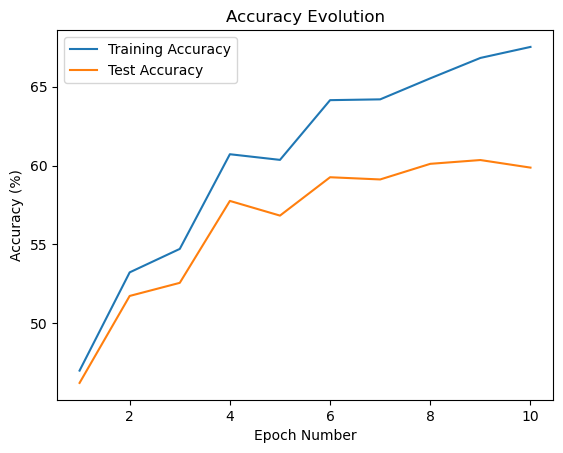

In [13]:
# TODO
# Plotting the accuracy evolution
epochs = range(1, 11)
plt.plot(epochs, train_accuracy_normal_list, label='Training Accuracy')
plt.plot(epochs, test_accuracy_normal_list, label='Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Evolution')
plt.legend()
plt.show()

What do you observe in the accuracy plot, in particular if you compare the train and test accuracy? Do you have an explanation for that?

In my model case I would say that we see that the test accuracy is lower than the training accuracy. This isn't wrong because the model is fitted to the training data and with increasing epochs the variance of the data is increased. So thats why we see the difference between the training and test accuracy.

### 3.4 Augmentation

Please apply random horizontal flipping, random cropping with padding=4, and ColorJitter to the CIFAR10 images and visualize a few pairs of augmented images against their original.

Files already downloaded and verified
Files already downloaded and verified


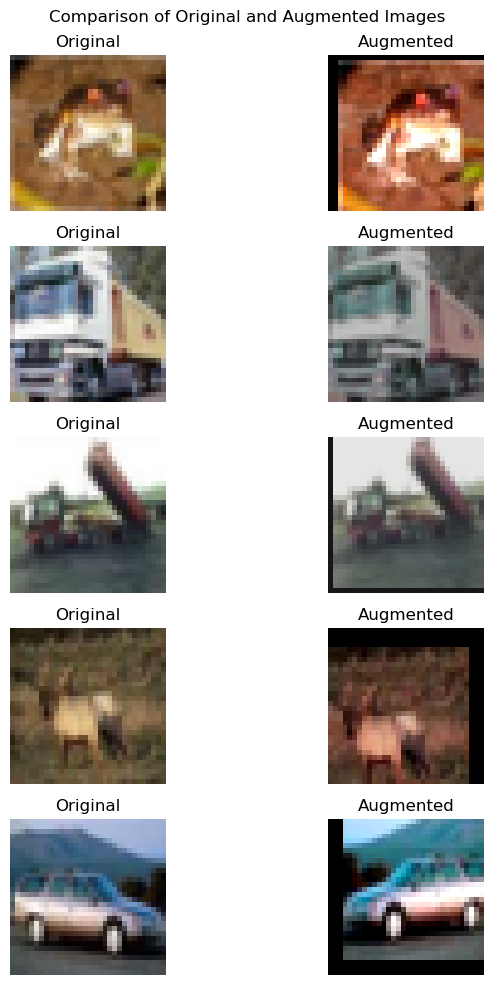

In [14]:
# TODO
trainset_original = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=T.Compose([
                           T.ToTensor()
                       ]))

# Apply augmentations to the dataset
augmented_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=32, padding=4),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor()
])

trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True, transform=augmented_transform)

# Visualize a few pairs of original and augmented images
num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2*num_samples))
fig.suptitle('Comparison of Original and Augmented Images')

for i in range(num_samples):
    # Plot original image
    original_img, _ = trainset_original[i]
    axes[i, 0].imshow(original_img.permute(1, 2, 0))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # Plot augmented image
    augmented_img, _ = trainset_augmented[i]
    axes[i, 1].imshow(augmented_img.permute(1, 2, 0))
    axes[i, 1].set_title('Augmented')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

Train your model using the same setup as above, however, with additional normalization (normalize your input images channel-wise using μ = 0.5 and σ = 0.5) and data augmentation.

In [15]:
# TODO
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=32, padding=4),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=T.Compose([
                                           T.ToTensor(),
                                           T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ]))
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = Net()
model = model.to(device)

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop with evaluation and accuracy tracking
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(10):  # 10 epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Evaluate on training set
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
    train_accuracy = 100 * correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    test_accuracy_list.append(test_accuracy)




Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 1.926
[2,  2000] loss: 1.656
[3,  2000] loss: 1.569
[4,  2000] loss: 1.515
[5,  2000] loss: 1.475
[6,  2000] loss: 1.444
[7,  2000] loss: 1.411
[8,  2000] loss: 1.387
[9,  2000] loss: 1.374
[10,  2000] loss: 1.355


Plot the accuracy of this model and the one you trained before over time. Make sure to use proper axis labels and a meaningful legend.

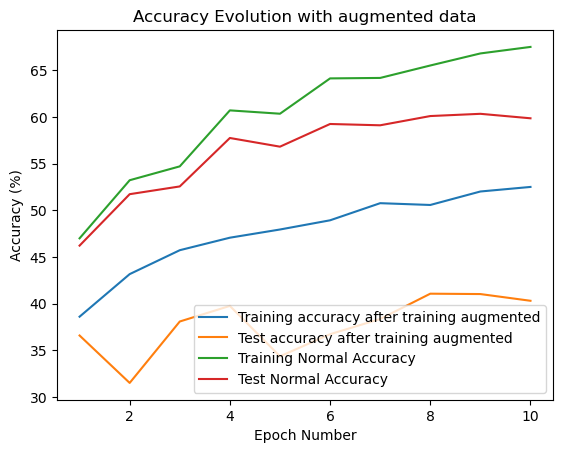

In [16]:
# TODO
# Plotting the accuracy evolution
epochs = range(1, 11)
plt.plot(epochs, train_accuracy_list, label='Training accuracy after training augmented')
plt.plot(epochs, test_accuracy_list, label='Test accuracy after training augmented')
plt.plot(epochs, train_accuracy_normal_list, label='Training Normal Accuracy')
plt.plot(epochs, test_accuracy_normal_list, label='Test Normal Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Evolution with augmented data')
plt.legend()
plt.show()

Based on your results, provide a brief discussion of why the extra normalization and augmentation improves/harms the performance of your model.

Augmented data harm my model (lower training and test accuracy). One of the reasons could be that by augmenting my data I am creating data that is not on the manifold (not valid data). So my model is learning patterns from these kind of data. When the time comes (test set) to predict data that is not augmented (healthy or good data) then it is making false predictions based on the learned patterns from the augmented data.

---
## Task 4: Activation and Saliency Maps

In this task, we will try to visualize what CNNs learn by means of the activation
map, which is considered to be more informative than just visualizing e.g. the
kernel weights.

### 4.1 Instantiate a pre-traind ResNet18

In [11]:
from torchvision.models import resnet18

############ your code here ############
# Instantiate your model ResNet18
# turn the model into evaluation mode
# and print out the architecture 

# TODO
model = resnet18(weights=True)
model.eval()
print(model)

############ end of your code############

c:\Users\Ilir\anaconda3\envs\gen-ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.2 Intermediate Activation Maps

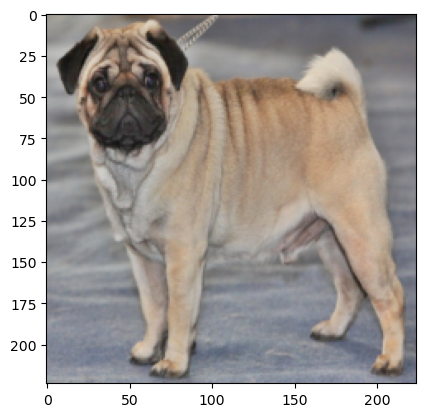

In [21]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the provided image and get the output
image = Image.open('pug.jpg')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

def show_tensor(tensor):
    if tensor.ndim == 4:
        temp = tensor.squeeze()
    else: temp=tensor
    plt.imshow(temp.cpu().permute(1,2,0))

show_tensor(X.squeeze())
model.to(device)
# TODO
output = model(X)

Store intermediate activation maps..


In [22]:
############ your code here ############
# activation_maps = [] # or
# activation_maps = {}
# Define the layers you want to extract
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
train_nodes, eval_nodes = get_graph_node_names(model)
print('Training nodes: ',train_nodes)
print('Evaluation nodes: ',eval_nodes)
return_nodes = {
    'conv1': 'conv1_output',
    'layer2.1.conv2': 'layer2_1_conv2_output'
}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)
outputs = feature_extractor(X) # feed image to model and get the outputs for the activations
conv1_activations = outputs['conv1_output']
layer2_1_conv2_output = outputs['layer2_1_conv2_output']
############ end of your code############

Training nodes:  ['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.do

### 4.3 Visualize the Activation Maps

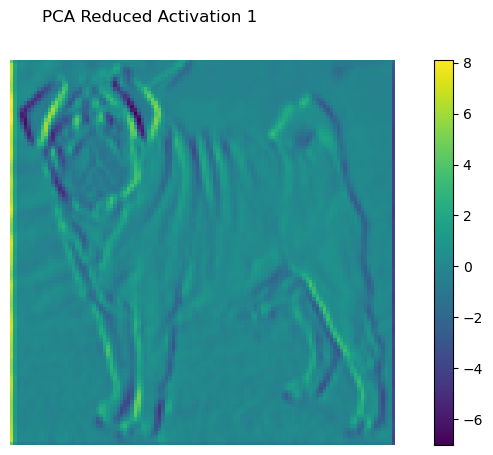

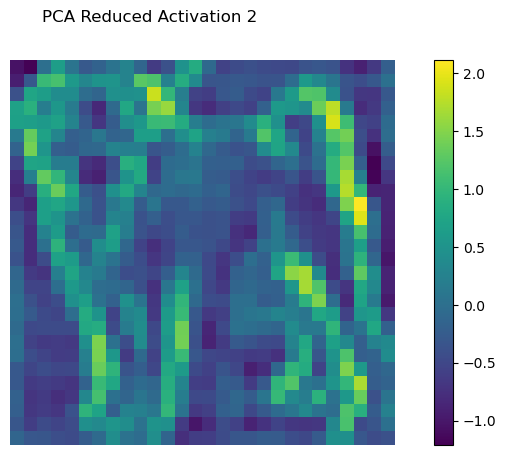

In [23]:
############ your code here ############
# reduce your activation maps' channel to a 'plottable' number
# you can use pca or any dimensionality reduction methods
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

conv1_activations = conv1_activations.cpu().detach()
n, c, h, w = conv1_activations.shape
activation_reshaped = conv1_activations.permute(0, 2, 3, 1).reshape(-1, c)
pca_result = pca.fit_transform(activation_reshaped)
pca_result = pca_result.reshape(n, h, w)

plt.figure(figsize=(10, 5))
plt.suptitle('PCA Reduced Activation 1')
plt.imshow(pca_result[0], cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.show()

layer2_1_conv2_output = layer2_1_conv2_output.cpu().detach()
n, c, h, w = layer2_1_conv2_output.shape
activation_reshaped_2 = layer2_1_conv2_output.permute(0, 2, 3, 1).reshape(-1, c)
pca_result_2 = pca.fit_transform(activation_reshaped_2)
pca_result_2 = pca_result_2.reshape(n, h, w)

plt.figure(figsize=(10, 5))
plt.suptitle('PCA Reduced Activation 2')
plt.imshow(pca_result_2[0], cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.show()

### 4.4 Plot Image and Activation Map

<Figure size 1000x500 with 0 Axes>

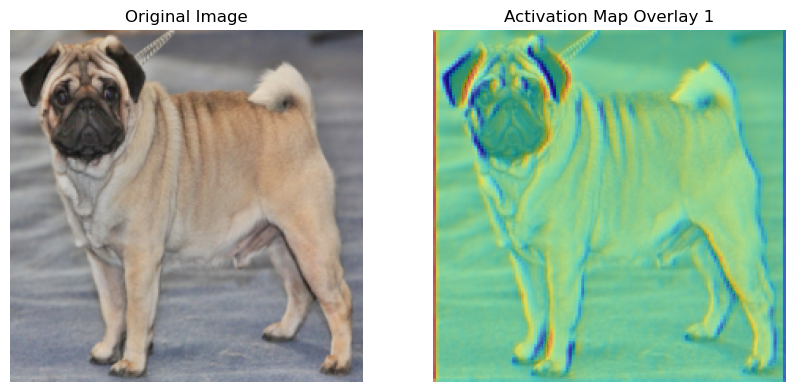

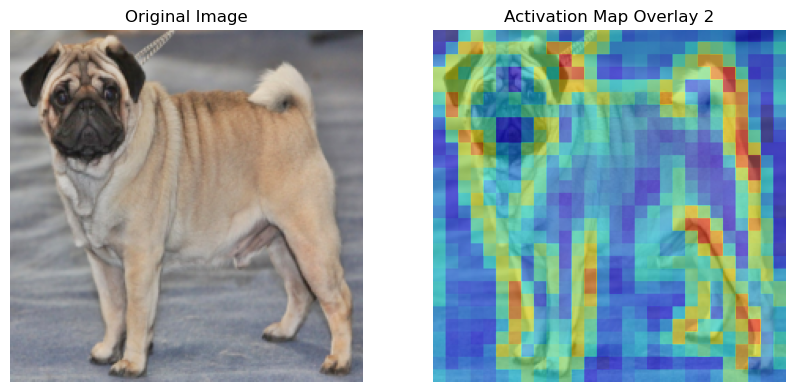

In [24]:
############ your code here ############
# visualize one of the activation maps on top of the original image
# you may need image resampling for this and the imshow(...,alpha=)
# value to overlap images with transparency.
import torch.nn.functional as F

def create_pca_result_from_activation(activation_input):
    pca = PCA(n_components=1)
    activation_input = activation_input.cpu().detach()
    n, c, h, w = activation_input.shape
    activation_reshaped = activation_input.permute(0, 2, 3, 1).reshape(-1, c)
    pca_result = pca.fit_transform(activation_reshaped)
    pca_result_reshaped = pca_result.reshape(n, h, w)
    pca_result_reshaped = (pca_result_reshaped - pca_result_reshaped.min()) / (pca_result_reshaped.max() - pca_result_reshaped.min())

    # Convert PCA result to a PIL image
    pca_image = Image.fromarray((pca_result_reshaped[0] * 255).astype(np.uint8))

    # Resize the image
    upsampled_pca_image = pca_image.resize((224, 224), Image.NEAREST)

    # Convert back to numpy array
    upsampled_pca_result = np.array(upsampled_pca_image) / 255.0  # Normalize to [0, 1]

    return upsampled_pca_result

# Create feature extractor
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)
outputs = feature_extractor(X) # feed image to model and get the outputs for the activations
conv1_activations = outputs['conv1_output']
layer2_1_conv2_output = outputs['layer2_1_conv2_output']

res_1 = create_pca_result_from_activation(conv1_activations)
res_2 = create_pca_result_from_activation(layer2_1_conv2_output)


plt.figure(figsize=(10, 5))

X_tmp=X.squeeze() # new variable for the pug image from 4.2

# Plot the original image and the overlay for the first activation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_tmp.cpu().permute(1,2,0))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_tmp.cpu().permute(1,2,0))
plt.imshow(res_1, cmap='jet', alpha=0.5)  # Overlay with some transparency
plt.title('Activation Map Overlay 1')
plt.axis('off')
plt.show()

# Plot the original image and the overlay for the second activation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_tmp.cpu().permute(1,2,0))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_tmp.cpu().permute(1,2,0))
plt.imshow(res_2, cmap='jet', alpha=0.5)
plt.title('Activation Map Overlay 2')
plt.axis('off')
plt.show()
############ end of your code############

When plotting the activation maps over the original image we can see which features of the image the convolutional layers extract. I think that it resembles the way humans intuition and what we look for when looking at an image in order to classify it.

### 4.5 Saliency Map
Introduced in: *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*

In [18]:
# illustrate how gather() works
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

# load the images
names = ['catdog_243.png', 'catdog_243.png', 'snake_56.png', 'spider_72.png']

X = [np.array(Image.open(name).convert('RGB')) for name in names]
y = [int(s.rsplit('_')[1].rsplit('.')[0]) for s in names]

# intentionally change the label to a wrong one
y[1] = 285

def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Lambda(lambda x: x[None]),  # equivalent to unsqueeze()
    ])
    return transform(img)

tensor([[-0.2788,  0.1875,  0.1971, -0.1869, -0.5441],
        [-0.5406, -1.0423,  2.9465, -0.7160,  0.1832],
        [ 0.4536,  0.2288, -0.5746,  0.2324, -0.3095],
        [ 1.8809, -0.8038, -1.1693,  0.4736,  1.1976]])
tensor([1, 2, 1, 3])
tensor([0.1875, 2.9465, 0.2288, 0.4736])


#### a) Complete the saliency map function.

loss  tensor(1.3960, device='cuda:0', grad_fn=<NllLossBackward0>)


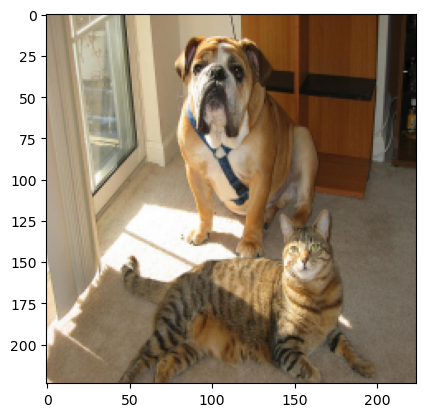

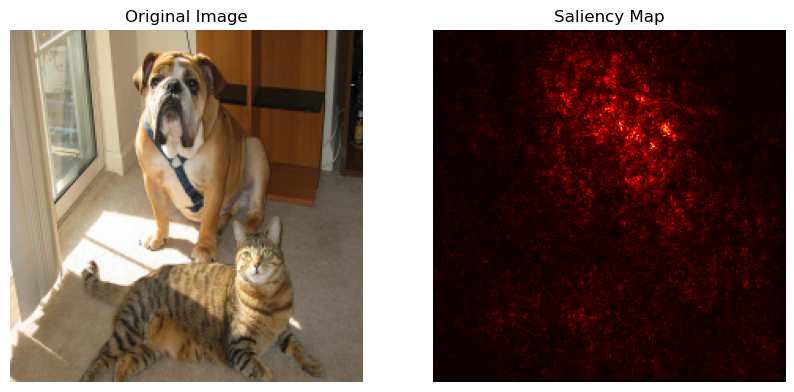

loss  tensor(5.0527, device='cuda:0', grad_fn=<NllLossBackward0>)


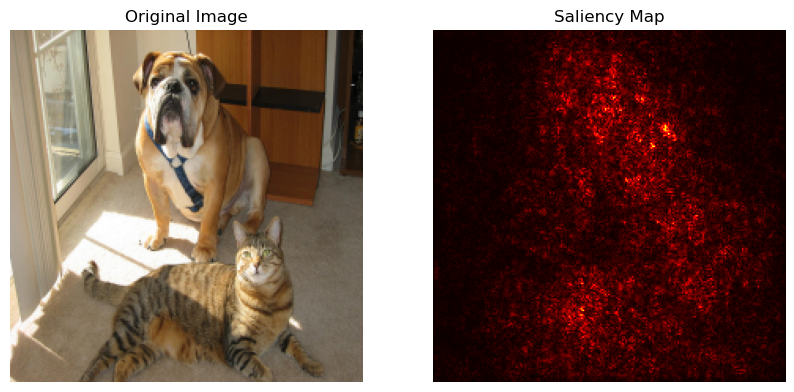

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = X.clone().detach().to(device)
    X_var.requires_grad = True
    y_var = y.clone().detach().to(device)
    saliency = None

    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    prediction = model(X_var)
    loss = criterion(prediction,y_var)
    model.zero_grad()
    print('loss ', loss )
    loss.backward()
    saliency = X_var.grad.abs().max(dim=1)[0]
    saliency = saliency.cpu()
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency


def visualize_saliency(image, saliency):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Saliency map
    axes[1].imshow(saliency.squeeze().cpu(), cmap='hot')
    axes[1].set_title('Saliency Map')
    axes[1].axis('off')

    plt.show()
    

def show_tensor(tensor):
    if tensor.ndim == 4:
        temp = tensor.squeeze()
    else: temp=tensor
    plt.imshow(temp.cpu().permute(1,2,0))

image = Image.open('catdog_243.png')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
X_one = transform(image).unsqueeze(dim=0)
show_tensor(X_one.squeeze())

#bull mastiff
y_one = torch.tensor([243],dtype=torch.long)
saliency = saliency_maps(X_one,y_one,model)
visualize_saliency(X_one,saliency)

#egyptian cat
y_two = torch.tensor([285],dtype=torch.long)
saliency = saliency_maps(X_one,y_two,model)
visualize_saliency(X_one,saliency)

#### b) Visualize the original images together with the saliency maps.

Visualize the original image with the saliency maps together and provide a short discussion on why different ground truth labels with even the same input image would yield different saliency maps, for instance, the catdog_243.png image with y = 243 (bull mastiff) and y = 285 (Egyptian cat).

loss  tensor(3.3561, device='cuda:0', grad_fn=<NllLossBackward0>)


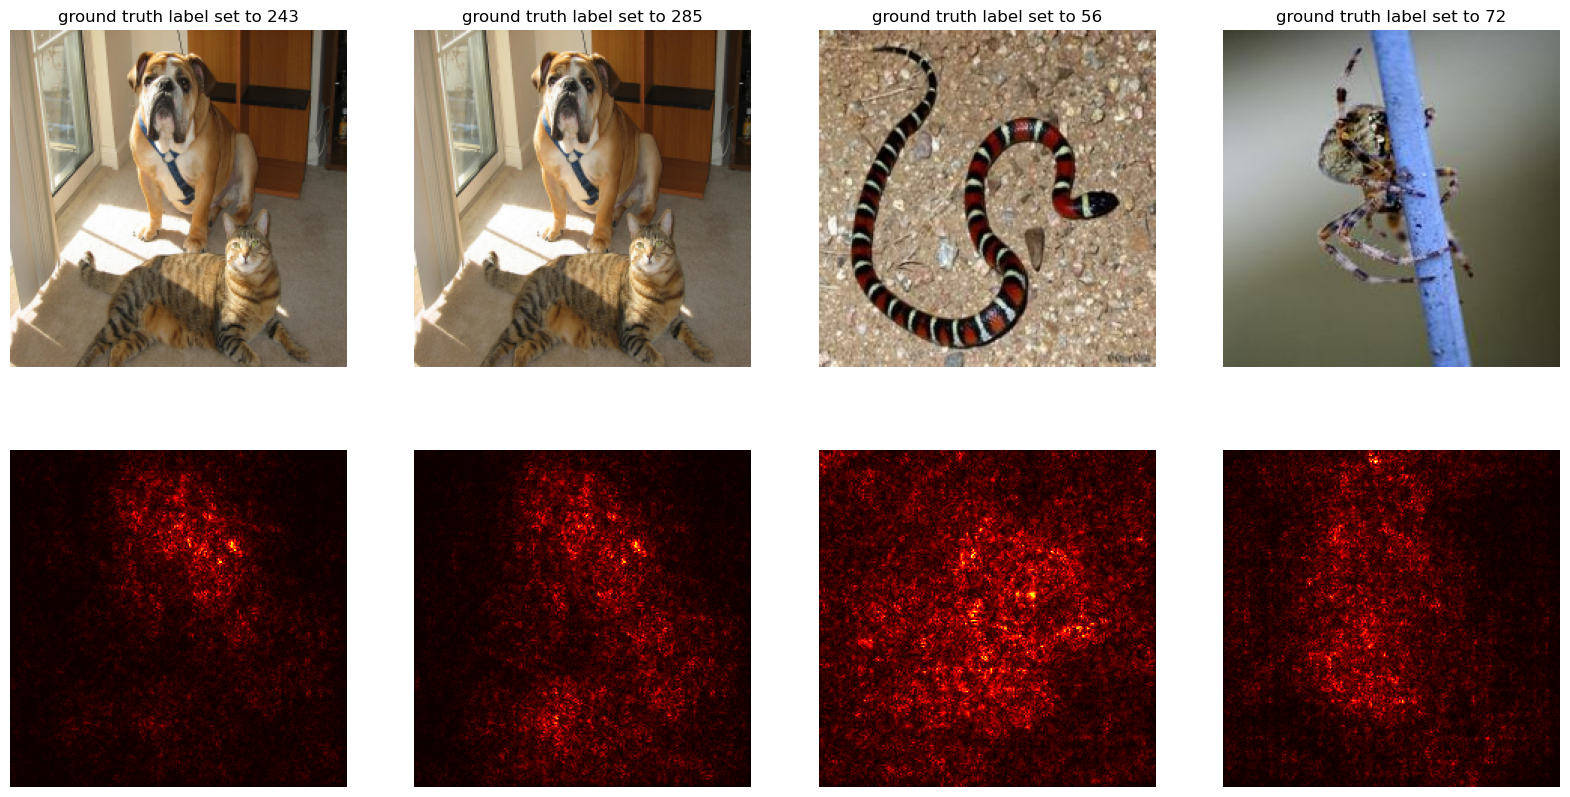

In [9]:
# Please use the same pre-trained network from the previous task for this task


# if you finished the task 3.1 and defined your model, then this function should run flawlessly
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    # Compute saliency maps for images in X
    saliency = saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = len(X)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title('ground truth label set to {}'.format(y[i]))
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(20, 10)
    plt.show()

show_saliency_maps(X, y)

We get different saliency maps for the same image because each class in a neural network model is associated with unique features. For bull mastiff, the model will focus on features typical of a dog, such as its fur texture, nose, and shape of the ears. For egyptian cat the model will highlight features characteristic of a cat, such as the body posture. Since the features important for identifying a bull mastiff differ significantly from those for an Egyptian cat, the saliency maps will highlight different parts of the same image

---